In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

(720, 1280, 3)


Text(0.5,1,'Undistorted Image')

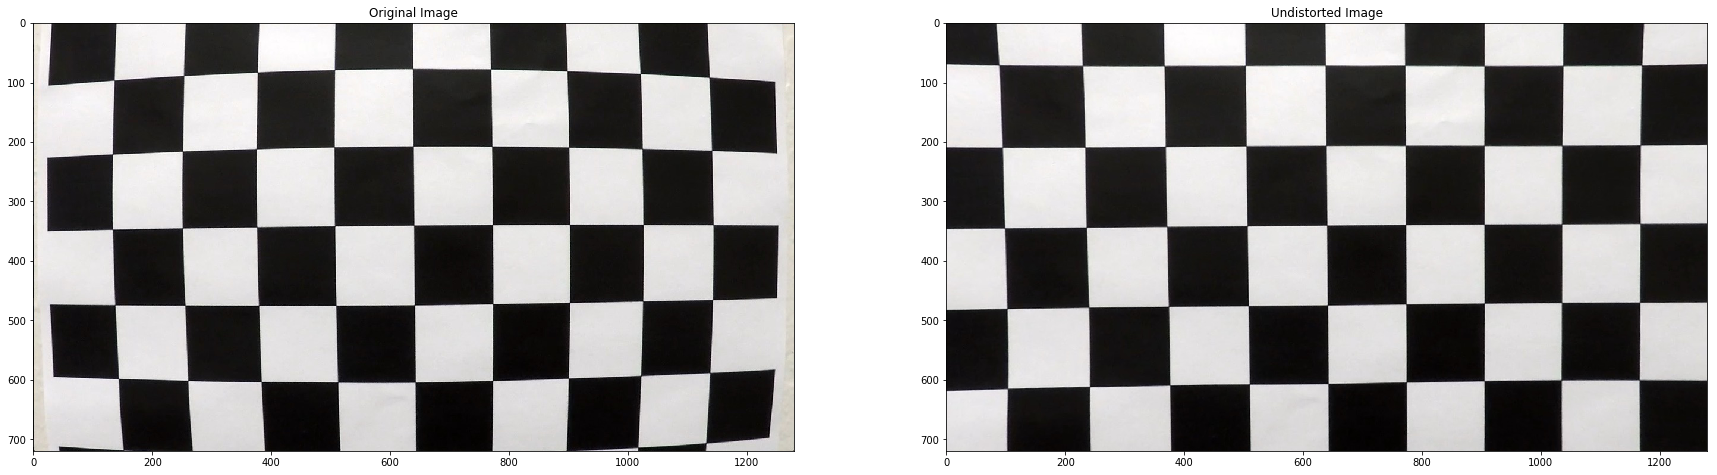

In [2]:
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)  
objpoints, imgpoints=[],[]
images = glob.glob('camera_cal/calibration*.jpg')


for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    
    if ret==True:
    
        objpoints.append(objp)
        imgpoints.append(corners)

   
ret, mtx, dist, rvecs, tvecs= cv2.calibrateCamera(objpoints, imgpoints, gray.shape[: :-1], None, None)
        
       

img =mpimg.imread('camera_cal/calibration1.jpg')
undist=cv2.undistort(img, mtx, dist, None, mtx)

print(img.shape)
f, axes= plt.subplots(1,2,figsize=(30,30))

cv2.imwrite('output_images/undistorted_calibration1.png', undist)       
axes[0].imshow(img)
axes[0].set_title("Original Image")
axes[1].imshow(undist)
axes[1].set_title("Undistorted Image")

    UNDISTORTING THE IMAGES

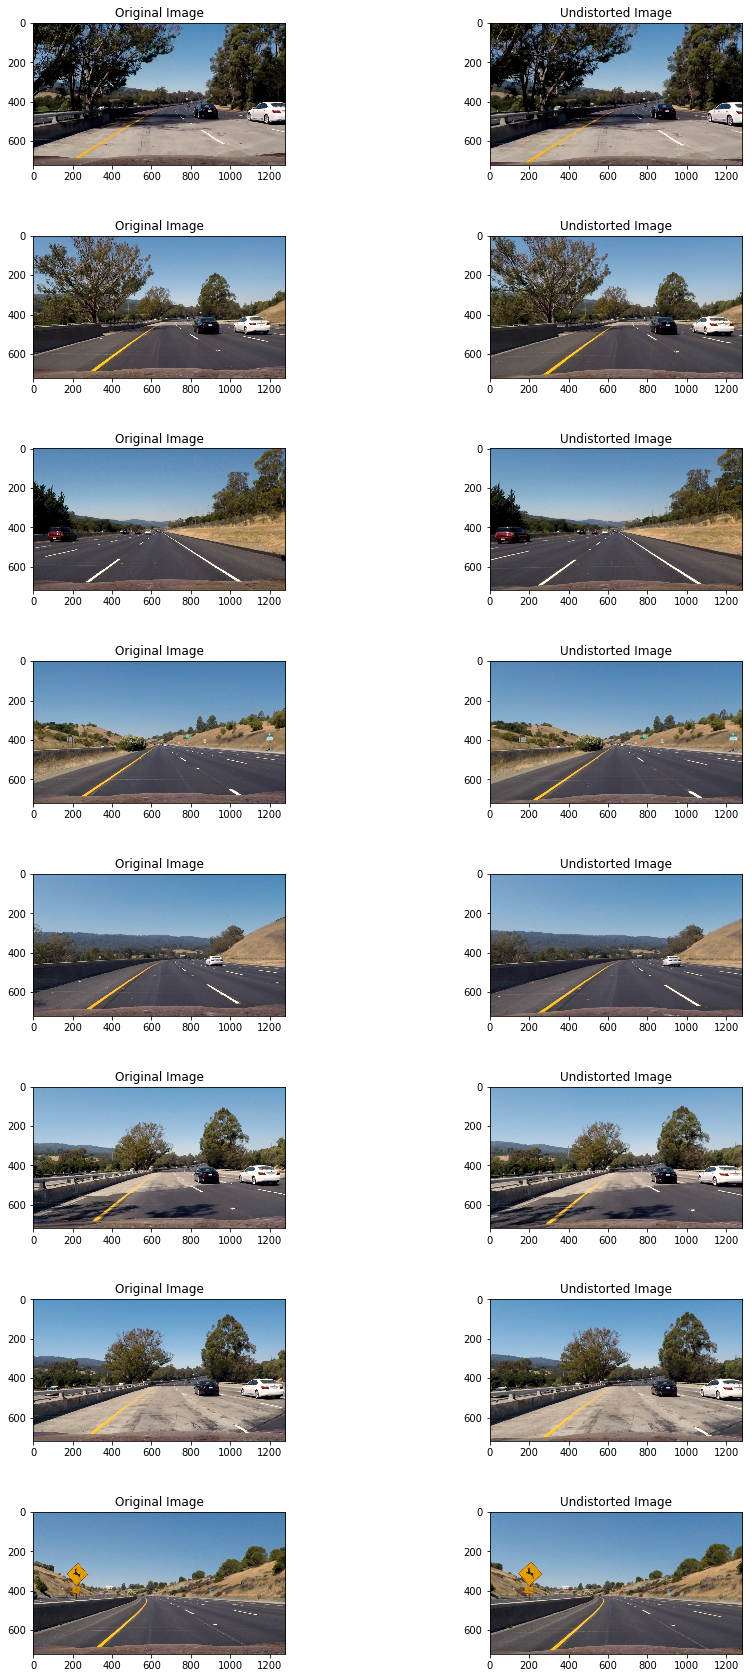

In [3]:
images = glob.glob('test_images/*.jpg')
f, axes= plt.subplots(8,2,figsize=(15,30))
f.subplots_adjust(hspace=0.5)
index=-1
for  fname in images:
    index+=1
    img=mpimg.imread(fname)
    undist=cv2.undistort(img, mtx, dist, None, mtx)
    axes[index,0].imshow(img)
    axes[index,0].set_title("Original Image")
    axes[index,1].set_title("Undistorted Image")
    axes[index,1].imshow(undist)
    





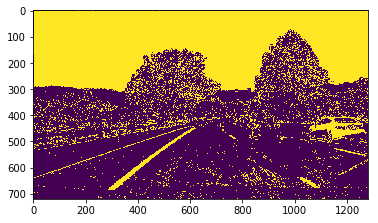

In [4]:
def gradient(img, sobel_kernel=3, dirthresh=(np.pi/6, np.pi/2), absthresh=(10,150)):
     gray=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)                #convert to grayscale
     sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)                #sobel in x direction
     abs_sobel=np.absolute(sobelx)
    
     scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
     
     sbinary = np.zeros_like(scaled_sobel)
     sbinary[(scaled_sobel >= absthresh[0]) & (scaled_sobel <=absthresh[1])] = 1
     
        
     sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
     sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
     direction=np.arctan2(np.absolute(sobely),np.absolute(sobelx))
     binary_output = np.zeros_like(direction)
     binary_output[(direction >= dirthresh[0]) & (direction <= dirthresh[1])] = 1
     
     a=np.zeros_like(direction)
     a[(binary_output==1) & (sbinary==1)] =1
        
     return a


def color(img, threshold=[100,255]):
     hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
     yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    
     s_channel = hls[:,:,2]
     l_channel = hls[:,:,1]
     y_channel = yuv[:,:,0]
     
     binary_outputS=np.zeros_like(s_channel)
     binary_outputS[((s_channel > threshold[0]) & (s_channel <= threshold[1])) ] = 1
    
     binary_outputL=np.zeros_like(s_channel)
     binary_outputL[((l_channel > threshold[0]) & (l_channel <= threshold[1])) ] = 1
    
     binary_outputY=np.zeros_like(s_channel)
     binary_outputY[((y_channel > threshold[0]) & (y_channel <= threshold[1])) ] = 1
     
     final=np.zeros_like(s_channel)
     final[(binary_outputS==1) & (binary_outputL==1) & (binary_outputY==1)]=1
        
     return final



def combined(img):
    a1=gradient(img)
    a2=color(img)
    f=np.zeros_like(a1)
    f[(a1==1) | (a2==1) ]=1
    return f
s=mpimg.imread('test_images/test1.jpg')
a=combined(s)
plt.imshow(a)


     
    
    
    

True

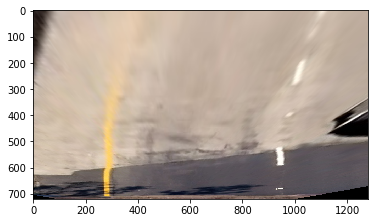

In [5]:
img=mpimg.imread('test_images/test4.jpg')
src=np.float32([[150, 720], [590,450], [700, 450],[1250,720] ])
dst=np.float32([[200, 720], [200, 0], [980, 0], [980, 720]])
M = cv2.getPerspectiveTransform(src, dst)
M_inv=cv2.getPerspectiveTransform(dst, src)
img_size = (img.shape[1], img.shape[0])
warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(warped)
cv2.imwrite('output_images/warped.jpg', warped)

True

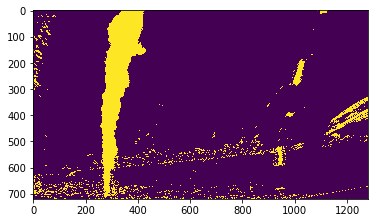

In [6]:
#a=mpimg.imread('output_images/binary_test5.jpg')
final_w=combined(warped)
plt.imshow(final_w)
cv2.imwrite('d.jpg', final_w)

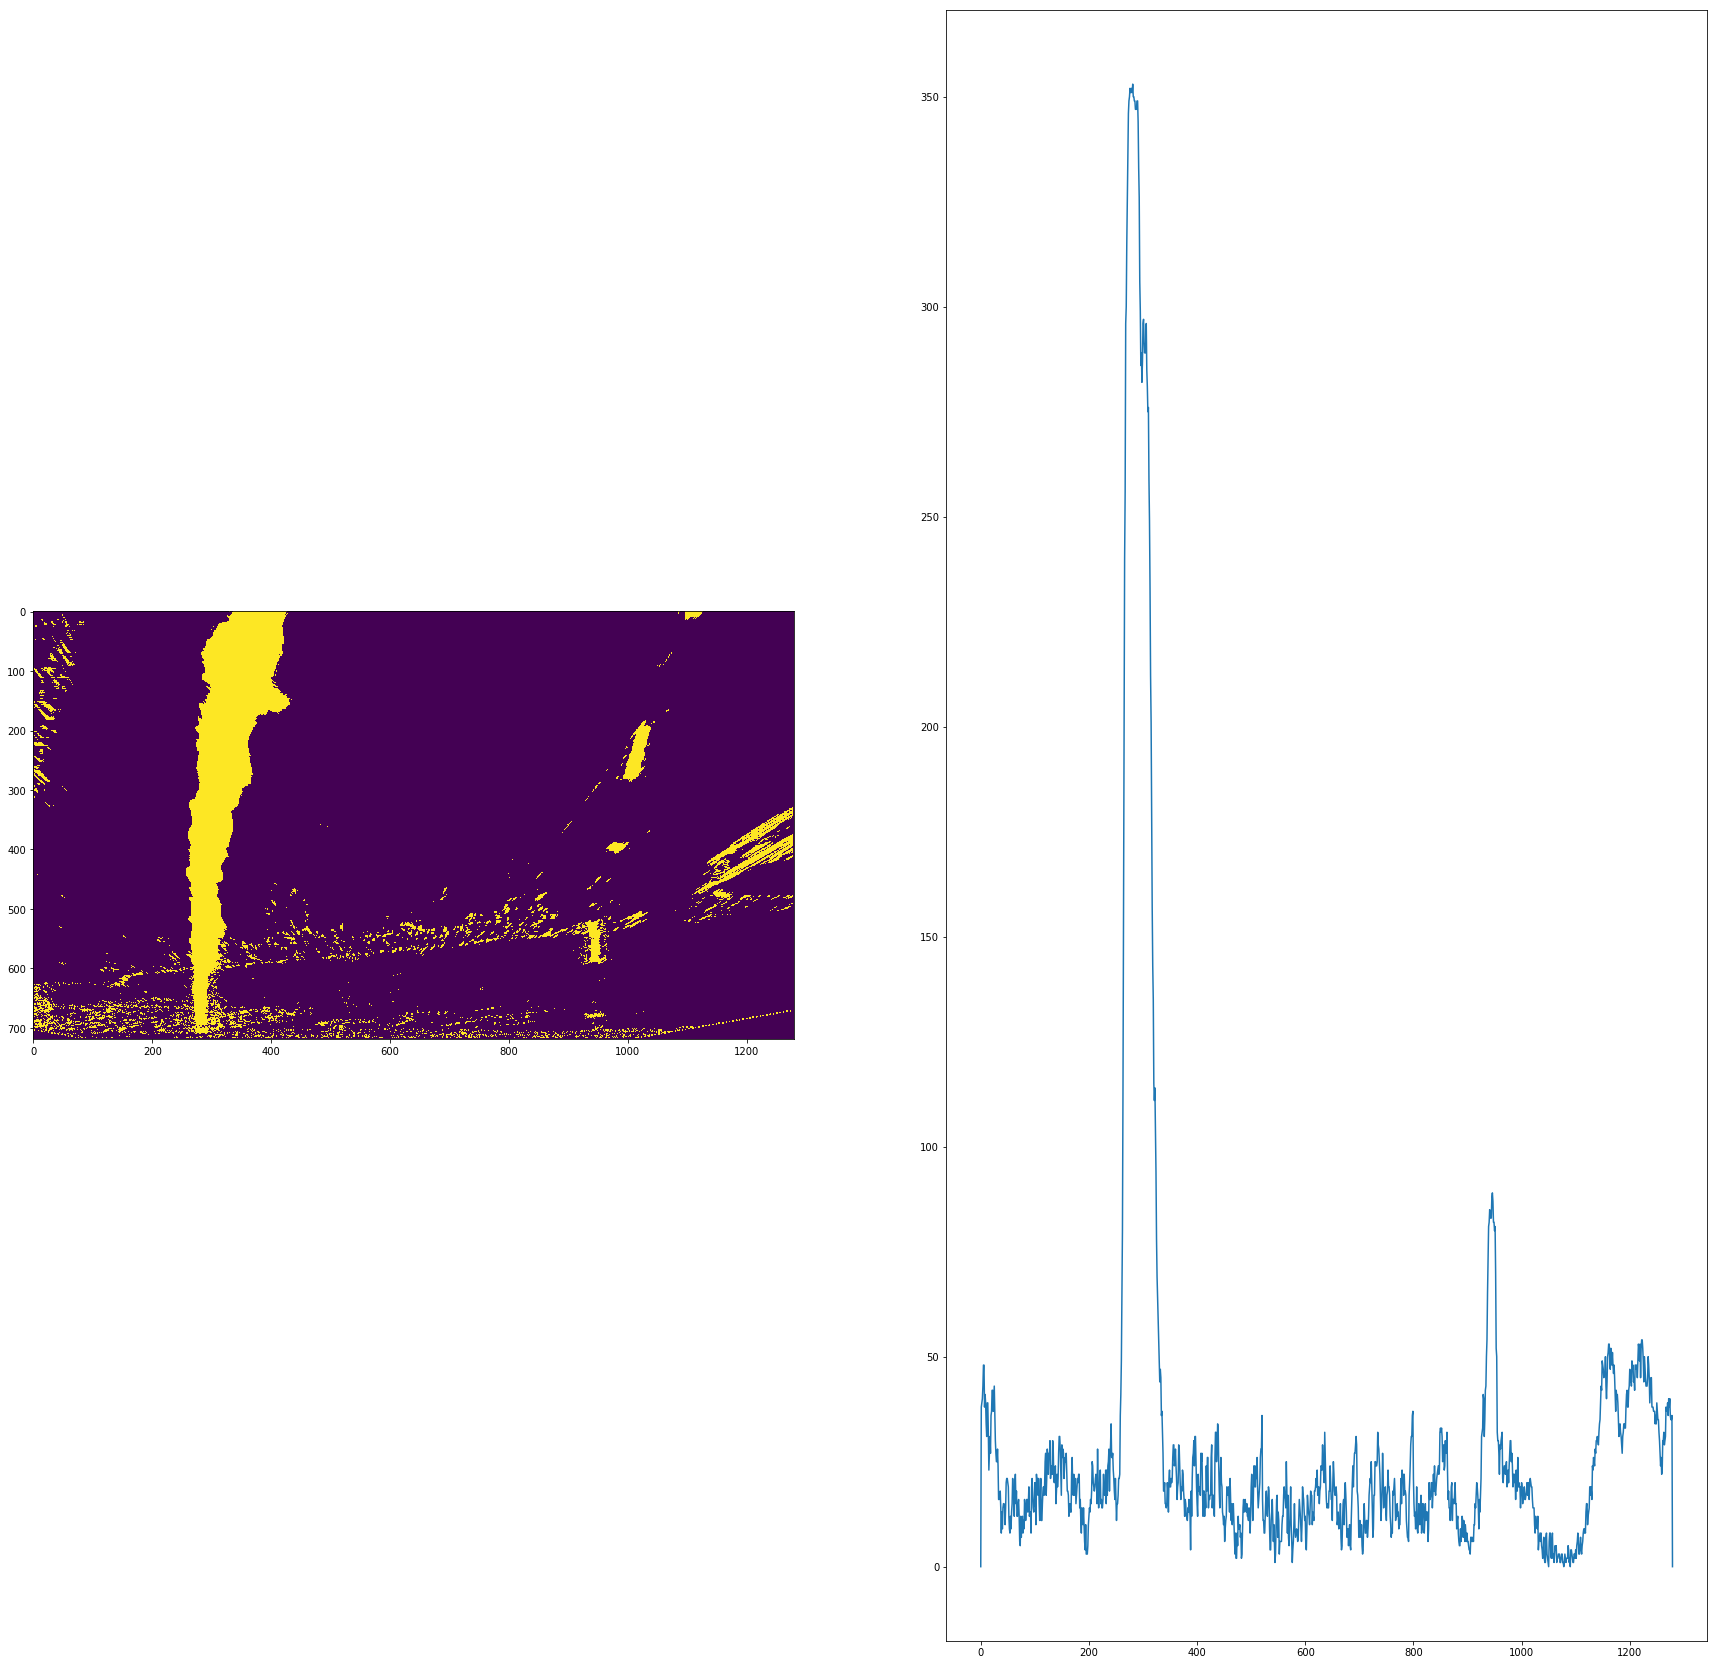

In [7]:
def histogram(img):
    bottom_half = img[img.shape[0]//2:,:]
    histogram = np.sum(bottom_half, axis=0)
    return histogram
f, axes= plt.subplots(1,2,figsize=(30,30))
hist=histogram(final_w)
axes[0].imshow(final_w)
axes[1].plot(hist)


In [15]:
def SlidingWindowSearch(binary_warped, plot=False):

    hist = histogram(binary_warped)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(hist.shape[0]/2)
    leftx_base = np.argmax(hist[:midpoint])
    rightx_base = np.argmax(hist[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        if(plot==True):
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    
    
    return left_fit,right_fit,left_lane_inds,right_lane_inds,out_img


            

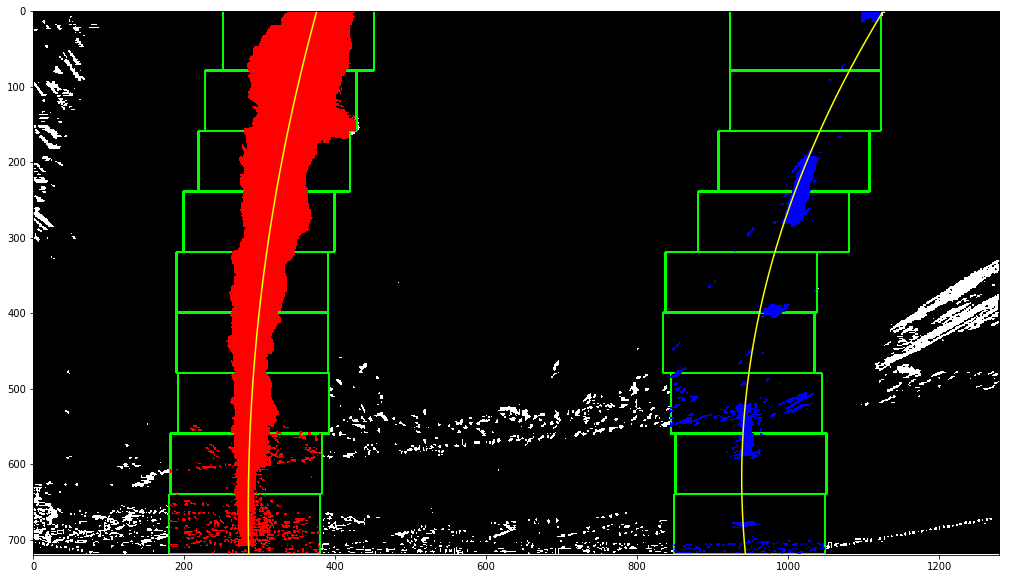

In [16]:
def VisualizeSlidingWindow(binary_warped, left_fit,right_fit, left_lane_inds, right_lane_inds,out_img):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    plt.figure(figsize=(20,10))
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    #return out_img

l,r,ld,rd,o=SlidingWindowSearch(final_w, plot=True)
VisualizeSlidingWindow(final_w,l,r,ld,rd,o)

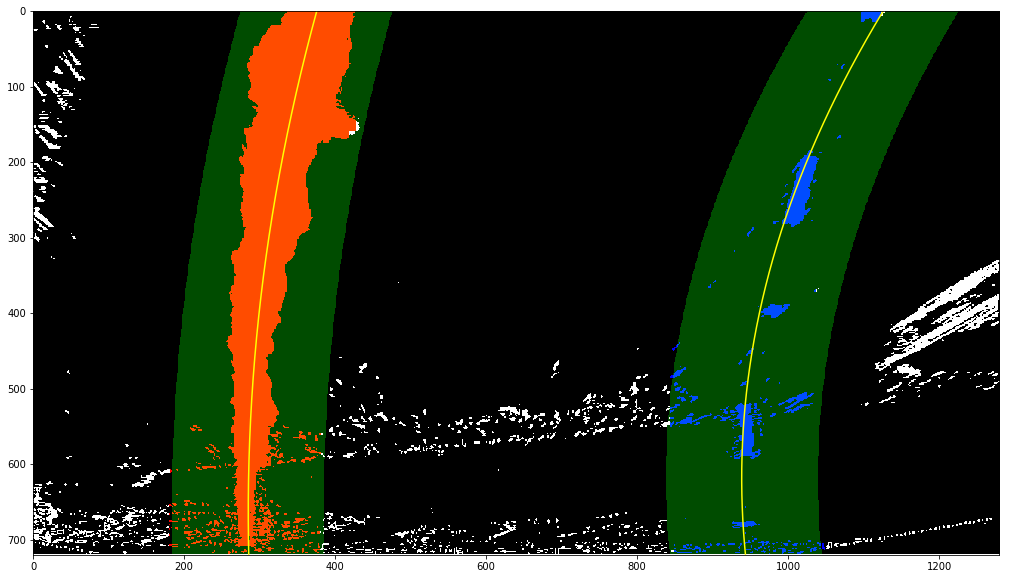

In [19]:
def VisualizeLaneDetection(binary_warped, left_fit,right_fit, left_lane_inds, right_lane_inds,out_img):
    margin = 100
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
   
    
 
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    
    plt.figure(figsize=(20,10))
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

l,r,ld,rd,o=SlidingWindowSearch(final_w, plot=False)
VisualizeLaneDetection(final_w,l,r,ld,rd,o)


In [23]:
def DrawLine(original_image,binary_warped, left_fit, right_fit):
    
    h,w= binary_warped.shape
    Minv = cv2.getPerspectiveTransform(dst, src)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] 
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
   
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    #axes[index+1].imshow(newwarp)
    # Combine the result with the original image
    result = cv2.addWeighted(original_image, 1, newwarp, 0.5, 0)
    return result



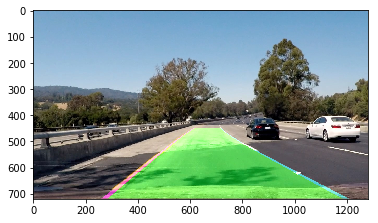

In [25]:
originalImage=mpimg.imread('test_images/test4.jpg')
returnedOutput =  SlidingWindowSearch(final_w)
left_fit=returnedOutput[0]
right_fit=returnedOutput[1]
finalImage=DrawLine(originalImage,final_w,left_fit,right_fit)
plt.imshow(finalImage)

In [31]:
def CalculateRadiusOfCurvature(binary_warped,left_fit,right_fit):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    positionCar= binary_warped.shape[1]/2
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    
    y_eval=np.max(ploty)
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    
    left_lane_bottom = (left_fit[0]*y_eval)**2 + left_fit[0]*y_eval + left_fit[2]
    right_lane_bottom = (right_fit[0]*y_eval)**2 + right_fit[0]*y_eval + right_fit[2]
    
    actualPosition= (left_lane_bottom+ right_lane_bottom)/2
    
    distance= (positionCar - actualPosition)* xm_per_pix
    
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    return (left_curverad + right_curverad)/2, distance
    # Example values: 632.1 m    626.2 m


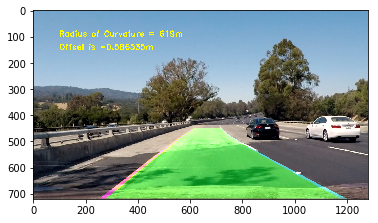

In [33]:
def pipeline(img):
    #step 1: undistort the image
    undist=cv2.undistort(img, mtx, dist, None, mtx)
    #step 2: warp the image
    warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    #step 3: get the binary image
    binary=combined(warped)
    #step 4: get the polynomials
    left_fit,right_fit,left_lane_inds,right_lane_inds,out_img=SlidingWindowSearch(binary)
    Draw=DrawLine(img, binary, left_fit, right_fit)
    curvature, offset=CalculateRadiusOfCurvature(warped, left_fit, right_fit)
    cv2.putText(Draw,"Radius of Curvature = " + str(int(curvature))+ "m", (100,100), 2, 1, (255,255,0),2)
    cv2.putText(Draw,"Offset is {:2f}".format(offset)+ "m", (100,150), 2, 1, (255,255,0),2)
    return Draw
img=mpimg.imread('test_images/test4.jpg')
d=pipeline(img)
plt.imshow(d)

In [34]:
import moviepy
from moviepy.editor import VideoFileClip
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')
processed_video = video_input1.fl_image(pipeline)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [05:15<00:00,  4.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 3min 11s, sys: 2.91 s, total: 3min 14s
Wall time: 5min 18s
